# Seq2Seq, Attention

褚则伟 zeweichu@gmail.com

在这份notebook当中，我们会(尽可能)复现Luong的attention模型

由于我们的数据集非常小，只有一万多个句子的训练数据，所以训练出来的模型效果并不好。如果大家想训练一个好一点的模型，可以参考下面的资料。

## 更多阅读

#### 课件
- [cs224d](http://cs224d.stanford.edu/lectures/CS224d-Lecture15.pdf)


#### 论文
- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
- [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025?context=cs)
- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1406.1078)


#### PyTorch代码
- [seq2seq-tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb)
- [Tutorial from Ben Trevett](https://github.com/bentrevett/pytorch-seq2seq)
- [IBM seq2seq](https://github.com/IBM/pytorch-seq2seq)
- [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py) 不错，要用seq2seq可以直接用


#### 更多关于Machine Translation
- [Beam Search](https://www.coursera.org/lecture/nlp-sequence-models/beam-search-4EtHZ)
- Pointer network 文本摘要
- Copy Mechanism 文本摘要
- Converage Loss 
- ConvSeq2Seq
- Transformer
- Tensor2Tensor

#### TODO
- 建议同学尝试对中文进行分词

#### NER
- https://github.com/allenai/allennlp/tree/master/allennlp


In [103]:
import os
import sys
import math
from collections import Counter #计数器
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk

读入中英文数据
- 英文我们使用nltk的word tokenizer来分词，并且使用小写字母
- 中文我们直接使用单个汉字作为基本单元

In [104]:
def load_data(file):
    cn = []
    en = []
    num_examples = 0
    with open(file, 'r') as f:
        for line in f:
            # print(line) #Anyone can do that.	任何人都可以做到。
            line = line.strip().split("\t") #分词后用逗号隔开
            # print(line) #['Anyone can do that.', '任何人都可以做到。']
            
            en.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])
            # BOS:beginning of sequence EOS:end of
            
            cn.append(["BOS"] + [c for c in line[1]] + ["EOS"])
            # split chinese sentence into characters
            # 中文一个一个字分词，可以尝试用分词器按词组分词，比如jieba.cut
    return en, cn

train_en, train_cn = load_data("nmt/en-cn/train.txt")
dev_en, dev_cn = load_data("nmt/en-cn/dev.txt")

In [105]:
print(train_en[:10]) # 打印前10句话看下
print(train_cn[:10])

[['BOS', 'anyone', 'can', 'do', 'that', '.', 'EOS'], ['BOS', 'how', 'about', 'another', 'piece', 'of', 'cake', '?', 'EOS'], ['BOS', 'she', 'married', 'him', '.', 'EOS'], ['BOS', 'i', 'do', "n't", 'like', 'learning', 'irregular', 'verbs', '.', 'EOS'], ['BOS', 'it', "'s", 'a', 'whole', 'new', 'ball', 'game', 'for', 'me', '.', 'EOS'], ['BOS', 'he', "'s", 'sleeping', 'like', 'a', 'baby', '.', 'EOS'], ['BOS', 'he', 'can', 'play', 'both', 'tennis', 'and', 'baseball', '.', 'EOS'], ['BOS', 'we', 'should', 'cancel', 'the', 'hike', '.', 'EOS'], ['BOS', 'he', 'is', 'good', 'at', 'dealing', 'with', 'children', '.', 'EOS'], ['BOS', 'she', 'will', 'do', 'her', 'best', 'to', 'be', 'here', 'on', 'time', '.', 'EOS']]
[['BOS', '任', '何', '人', '都', '可', '以', '做', '到', '。', 'EOS'], ['BOS', '要', '不', '要', '再', '來', '一', '塊', '蛋', '糕', '？', 'EOS'], ['BOS', '她', '嫁', '给', '了', '他', '。', 'EOS'], ['BOS', '我', '不', '喜', '欢', '学', '习', '不', '规', '则', '动', '词', '。', 'EOS'], ['BOS', '這', '對', '我', '來', '說', '是', '個

### 用train数据集来构建单词表

In [106]:
UNK_IDX = 0
PAD_IDX = 1
def build_dict(sentences, max_words=50000):
    word_count = Counter() # Counter 是实现的 dict 的一个子类，可以用来方便地计数。
    print(type(word_count))
    for sentence in sentences:
        for s in sentence:
            word_count[s] += 1  # 对每个单词开始计数
    ls = word_count.most_common(max_words) 
    #按每个单词数量排序前50000个,这个数字自己定的，不重复单词数没有50000
    #ls = [('BOS', 14533), ('EOS', 14533), ('.', 12521), ('i', 4045), .......
    print(len(ls)) #train_en：5491，train_cn=3193
    
    total_words = len(ls) + 2
    #加的2是留给"unk"和"pad"
    
    word_dict = {w[0]: index+2 for index, w in enumerate(ls)}
    # word_dict= {'BOS': 2, 'EOS': 3, '.': 4, 'i': 5, 'the': 6, 'to': 7,.......
    # 把每个单词转换成word_idx字典格式，词频最高的单词索引为2，0和1留给"unk"和"pad"
    
    word_dict["UNK"] = UNK_IDX # 0
    word_dict["PAD"] = PAD_IDX # 1
    return word_dict, total_words

en_dict, en_total_words = build_dict(train_en)
cn_dict, cn_total_words = build_dict(train_cn)
        
inv_en_dict = {v: k for k, v in en_dict.items()}
#en_dict.items()把字典转换成可迭代对象，取出键值，并调换键值的位置。
inv_cn_dict = {v: k for k, v in cn_dict.items()}

<class 'collections.Counter'>
5491
<class 'collections.Counter'>
3193


In [107]:
print(en_total_words)
print(list(en_dict.items())[:10]) # 取出前10个
print(list(en_dict.items())[-10:]) # 取出后10个，可以看到"unk"和"pad"在最后
print("---"*20)
print(cn_total_words)
print(list(cn_dict.items())[:10]) # 查看中文
print(list(cn_dict.items())[-10:]) 
print("---"*20)
print(list(inv_en_dict.items())[:10]) # 键值对调换
print(list(inv_cn_dict.items())[:10]) 

5493
[('BOS', 2), ('EOS', 3), ('.', 4), ('i', 5), ('the', 6), ('to', 7), ('you', 8), ('a', 9), ('is', 10), ('?', 11)]
[('opposition', 5485), ('springs', 5486), ('schoolroom', 5487), ('absence', 5488), ('fonder', 5489), ('field', 5490), ('educational', 5491), ('foster', 5492), ('UNK', 0), ('PAD', 1)]
------------------------------------------------------------
3195
[('BOS', 2), ('EOS', 3), ('。', 4), ('我', 5), ('的', 6), ('了', 7), ('你', 8), ('他', 9), ('是', 10), ('一', 11)]
[('鷹', 3187), ('鸚', 3188), ('鵡', 3189), ('寵', 3190), ('鳴', 3191), ('缓', 3192), ('黨', 3193), ('釘', 3194), ('UNK', 0), ('PAD', 1)]
------------------------------------------------------------
[(2, 'BOS'), (3, 'EOS'), (4, '.'), (5, 'i'), (6, 'the'), (7, 'to'), (8, 'you'), (9, 'a'), (10, 'is'), (11, '?')]
[(2, 'BOS'), (3, 'EOS'), (4, '。'), (5, '我'), (6, '的'), (7, '了'), (8, '你'), (9, '他'), (10, '是'), (11, '一')]


### 将train和dev数据集的单词全部转变成数字

In [108]:
def encode(en_sentences, cn_sentences, en_dict, cn_dict, sort_by_len=True):
    '''
        Encode the sequences. 
    '''
    length = len(en_sentences)
    #en_sentences=[['BOS', 'anyone', 'can', 'do', 'that', '.', 'EOS'],....
    
    out_en_sentences = [[en_dict.get(w, 0) for w in sent] for sent in en_sentences]
    # out_en_sentences=[[2, 328, 43, 14, 28, 4, 3], ....
    # en_dict.get(w, 0)，对一句话里的每个单词，如果出现在字典中，返回键w对应的值。没有就为0.
    # 因题库比较小，这里所有的单词向量都有非零索引。
    out_cn_sentences = [[cn_dict.get(w, 0) for w in sent] for sent in cn_sentences]

    # sort sentences by english lengths
    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))
      # sorted()排序,key参数可以自定义规则，按seq[x]的长度排序，最短句子的索引排在最前面。
      # 下面有个简单的示例。
       
    # 把中文和英文按照同样的顺序排序
    if sort_by_len:
        sorted_index = len_argsort(out_en_sentences)
        # sorted_index=[63, 1544, 1917, 2650, 3998, 6240, 6294, 6703, ....
        # 63说明最短的句子，在out_en_sentences中的索引为63的位置。
      
        out_en_sentences = [out_en_sentences[i] for i in sorted_index]
        # out_en_sentences=[[2, 475, 4, 3], [2, 1318, 126, 3], [2, 1707, 126, 3], ......
        # 按排序好的索引取出句子。
     
        out_cn_sentences = [out_cn_sentences[i] for i in sorted_index]
        # 中文是目标值，按英文句子的位置取出中文翻译的句子。
    return out_en_sentences, out_cn_sentences

train_en, train_cn = encode(train_en, train_cn, en_dict, cn_dict)
dev_en, dev_cn = encode(dev_en, dev_cn, en_dict, cn_dict)

In [109]:
# sorted示例
seq = [5,4,6,9,10]
print(sorted(range(5), key=lambda x: seq[x])) 
print(sorted(range(4), key=lambda x: seq[x]))

[1, 0, 2, 3, 4]
[1, 0, 2, 3]


In [110]:
print(train_en[:10])
print(train_cn[:10])
print("---"*20)
k=10000 # 
print([inv_cn_dict[i] for i in train_cn[k]]) #通过inv字典获取单词
print([inv_en_dict[i] for i in train_en[k]])
print(" ".join([inv_cn_dict[i] for i in train_cn[k]])) #通过inv字典获取单词
print(" ".join([inv_en_dict[i] for i in train_en[k]])) 

[[2, 475, 4, 3], [2, 1318, 126, 3], [2, 1707, 126, 3], [2, 254, 126, 3], [2, 1318, 126, 3], [2, 130, 11, 3], [2, 2045, 126, 3], [2, 693, 126, 3], [2, 2266, 126, 3], [2, 1707, 126, 3]]
[[2, 8, 87, 441, 6, 4, 3], [2, 119, 1368, 221, 3], [2, 982, 2028, 8, 4, 3], [2, 239, 239, 221, 3], [2, 151, 190, 221, 3], [2, 8, 546, 162, 14, 3], [2, 141, 488, 6, 221, 3], [2, 18, 489, 221, 3], [2, 189, 158, 221, 3], [2, 2110, 60, 221, 3]]
------------------------------------------------------------
['BOS', '他', '来', '这', '里', '的', '目', '的', '是', '什', '么', '？', 'EOS']
['BOS', 'for', 'what', 'purpose', 'did', 'he', 'come', 'here', '?', 'EOS']
BOS 他 来 这 里 的 目 的 是 什 么 ？ EOS
BOS for what purpose did he come here ? EOS


把全部句子分成batch

In [111]:
print(np.arange(0, 100, 15))
print(np.arange(0, 15))

[ 0 15 30 45 60 75 90]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [112]:
# 按句子的数量自制batch
def get_minibatches(n, minibatch_size, shuffle=True):
    idx_list = np.arange(0, n, minibatch_size) 
    if shuffle:
        np.random.shuffle(idx_list) #打乱数据
    minibatches = []
    for idx in idx_list:
        minibatches.append(np.arange(idx, min(idx + minibatch_size, n)))
        # 所有batch放在一个大列表里
    return minibatches

In [113]:
get_minibatches(100,15) #随机打乱的

[array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])]

In [114]:
def prepare_data(seqs):
    #seqs：每个batch的句子，一个batch的句子可能不一样长
    lengths = [len(seq) for seq in seqs]#每个batch里语句的长度统计出来
    n_samples = len(seqs) #一个batch有多少语句
    max_len = np.max(lengths) #取出最长的的语句长度，后面用这个做padding基准   
    x = np.zeros((n_samples, max_len)).astype('int32')
    # 按最长的句子先初始化全零矩阵，后面依次赋值
    # x：（batch_sizes * 最大句子长度）
    x_lengths = np.array(lengths).astype("int32")
    for idx, seq in enumerate(seqs):
        # 取出一个batch的每条语句和对应的索引
        x[idx, :lengths[idx]] = seq
        # 每条语句按行赋值给x，x会有一些零值没有被赋值。
        # 到这步相当于手动pad了，应该有专门的api来处理的
        
    return x, x_lengths #x_mask

def gen_examples(en_sentences, cn_sentences, batch_size):
    minibatches = get_minibatches(len(en_sentences), batch_size)
    all_ex = []
    for minibatch in minibatches: 
        # 按分好的batch取出中文和英文句子索引。
        mb_en_sentences = [en_sentences[t] for t in minibatch]        
        mb_cn_sentences = [cn_sentences[t] for t in minibatch]
        mb_x, mb_x_len = prepare_data(mb_en_sentences)
        # 每个batch长短不一的英文句子手动pad成统一长度
        mb_y, mb_y_len = prepare_data(mb_cn_sentences)
        # 每个batch长短不一的中文句子手动pad成统一长度
        
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
  # 这里把所有batch数据集合到一起。一个元组为一个batch的数据，所有batch组成一个大列表数据
  # 依次为每个batch的英文句子，英文句子长度，中文句子，中文句子长度
  
    return all_ex

batch_size = 64
train_data = gen_examples(train_en, train_cn, batch_size) # 训练集
random.shuffle(train_data) # 随机打乱batch，这个感觉跟上面的shuffle一样的功能
dev_data = gen_examples(dev_en, dev_cn, batch_size) # 验证集

In [115]:
# 打印第一个batch的信息
print(train_data[0][0].shape) # 一个batch英文句子维度
print(train_data[0][1].shape) # 一个batch英文句子长度维度
print(train_data[0][2].shape) # 一个batch中文句子维度
print(train_data[0][3].shape) # 一个batch中文句子长度维度
print(train_data[0])

(64, 10)
(64,)
(64, 17)
(64,)
(array([[   2,  266,    6, 3801,   49,  270,    6,  210,    4,    3],
       [   2,   12,   10, 3803,    7,   39,    9,  223,    4,    3],
       [   2,    5,   54,    8,    7,  183,   59,  516,    4,    3],
       [   2,    5,  113,   32, 1273,   49,  166, 3809,    4,    3],
       [   2,   21,  140, 1202,    6,  210,   50, 1006,    4,    3],
       [   2,   10,   44,    9, 2725,  954,   26,   28,   11,    3],
       [   2,    6, 1005,   17,    6,  351,   27, 3810,    4,    3],
       [   2,    9,  149,   17, 1344,   86, 1054,   59,    4,    3],
       [   2,   72,   49,   97,   23,   34, 1289,  278,    4,    3],
       [   2,   29,   30, 1386,   33,    9, 1758, 2726,    4,    3],
       [   2,    5,   63,    9, 2727,  108,   27, 1240,    4,    3],
       [   2,   16,   10,   71,  280, 2177,   69,   16,    4,    3],
       [   2,   25, 1015,   10,  128,  421,   26,   23,    4,    3],
       [   2,   31,    7,   14,  156,   10,    6,  394,    4,    3],
   

### 没有Attention的版本
下面是一个更简单的没有Attention的encoder decoder模型

In [116]:
# 编码
class PlainEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        #以英文为例，vocab_size=5493, hidden_size=100, dropout=0.2
        super(PlainEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        #这里的hidden_size为embedding_dim：一个单词的维度 =100
        
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)      
        #第一个参数为input_size ：也就是embedding_dim
        #第二个参数为hidden_size ：隐藏层维度

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths): 
        # x是输入的batch的所有句子，lengths：batch里每个句子的长度
        # x.sahpe = torch.Size([64, 10])
        # lengths= =tensor([10, 10, 10, ..... 10, 10, 10])
        # 因为需要把最后一个hidden state取出来，需要知道长度，因为句子长度不一样
        
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        #按照长度排序，descending=True长的在前。
        #返回两个参数，句子长度和排序后的索引
        # sorted_idx=tensor([41, 40, 46, 45,...... 19, 18, 63]) 41这个索引对应的句子说明是最长的。
        # sorted_len 和sorted_idx对应，句子长度的列表，从大到小
        
        x_sorted = x[sorted_idx.long()] 
        # 句子用新的idx，按长度排序
        
        embedded = self.dropout(self.embed(x_sorted))
        #embedded.shape =torch.Size([64, 10, 100])

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        #这个函数就是用来处理不同长度的句子的，看下这篇博客理解：https://www.cnblogs.com/sbj123456789/p/9834018.html
        packed_out, hid = self.rnn(packed_embedded)
        # hid.shape = torch.Size([1, 64, 100])
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        # out.shape = torch.Size([64, 10, 100])

        _, original_idx = sorted_idx.sort(0, descending=False)
        # 上面lengths.sort()过，已经打乱了batch的句子的顺序，所以得恢复原位置，不然跟中文对不上。  
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()
        #out.shape = torch.Size([64, 10, 100])
        #hid.shape = torch.Size([1, 64, 100])
        
        return out, hid[[-1]] # 有时候encoder的num_layers神经元层数多，需要取出最后一层

In [117]:
# 解码
class PlainDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        super(PlainDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, y, y_lengths, hid):
        #print(y.shape)=torch.Size([64, 12])
        #print(hid.shape)=torch.Size([1, 64, 100])
        #中文的y和y_lengths
        
        # 中文句子的长度也不一样，也要和上面一样，不同长度的句子，也应该去掉没用的神经元。
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()] #隐藏层也要排序
        # hid是Encoder的输出，和y_sorted都作为输入进入decoder层
        y_sorted = self.dropout(self.embed(y_sorted)) 
        # batch_size, output_length, embed_size
        
        # 下面跟上面一样一顿操作
        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid) #加上隐藏层
        #print(hid.shape)=torch.Size([1, 64, 100])
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        #print(output_seq.shape)=torch.Size([64, 12, 100])
        hid = hid[:, original_idx.long()].contiguous()
        #print(hid.shape)=torch.Size([1, 64, 100])
        
        
        output = F.log_softmax(self.out(output_seq), -1)
        # print(output.shape)=torch.Size([64, 12, 3195])
        # 输出的每个单词都有3195个向量
        
        return output, hid

In [118]:
lengths = torch.tensor([10,4,6,3,7])
lengths.sort(0, descending=True)

torch.return_types.sort(
values=tensor([10,  7,  6,  4,  3]),
indices=tensor([0, 4, 2, 1, 3]))

In [119]:
class PlainSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        #encoder是上面PlainEncoder的实例
        #decoder是上面PlainDecoder的实例
        super(PlainSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
       
    #把两个模型串起来 
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        #self.encoder(x, x_lengths)调用PlainEncoder里面forward的方法
        #返回forward的out和hid
        
        output, hid = self.decoder(y=y,y_lengths=y_lengths,hid=hid)
        #self.dencoder()调用PlainDecoder里面forward的方法
        
        return output, None

    def translate(self, x, x_lengths, y, max_length=10):
        #x是一个句子，用数值表示
        #y是句子的长度
        #y是“bos”的数值索引=2
        
        encoder_out, hid = self.encoder(x, x_lengths)
        # encoder_out.shape=torch.Size([1, 7, 100])，1是batch_size,7是句子长度
        # hid.shape=torch.Size([1, 1, 100])，
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            # 训练的时候y是一个句子，一起decoder训练
            # 测试的时候y是个一个词一个词生成的，所以这里的y是传入的第一个单词，这里是bos
            # 同理y_lengths也是1
            output, hid = self.decoder(y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)         
            #刚开始循环bos作为模型的首个输入单词，后续更新y，下个预测单词的输入是上个输出单词
            # output.shape = torch.Size([1, 1, 3195])
            # hid.shape = torch.Size([1, 1, 100])
            

            y = output.max(2)[1].view(batch_size, 1)
            # .max(2)在第三个维度上取最大值,返回最大值和对应的位置索引，[1]取出最大值所在的索引
            preds.append(y) # 每次循环输出的y值就是预测值
            # preds = [tensor([[5]], device='cuda:0'), tensor([[24]], device='cuda:0'), ... tensor([[4]], device='cuda:0')]
            # torch.cat(preds, 1) = tensor([[ 5, 24,  6, 22,  7,  4,  3,  4,  3,  4]], device='cuda:0')
        return torch.cat(preds, 1), None  

In [120]:
a = torch.rand([1, 2, 5])
print(a)
print(a.max(2))
a.max(2)[1]

tensor([[[0.7004, 0.5787, 0.6600, 0.9044, 0.4117],
         [0.5476, 0.0436, 0.0890, 0.1236, 0.1887]]])
torch.return_types.max(
values=tensor([[0.9044, 0.5476]]),
indices=tensor([[3, 0]]))


tensor([[3, 0]])

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout = 0.2
hidden_size = 100

In [122]:
#传入中文和英文参数
encoder = PlainEncoder(vocab_size=en_total_words,
                      hidden_size=hidden_size,
                      dropout=dropout)
decoder = PlainDecoder(vocab_size=cn_total_words,
                      hidden_size=hidden_size,
                      dropout=dropout)
model = PlainSeq2Seq(encoder, decoder)

In [123]:
# masked cross entropy loss
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):
        # target=tensor([[5,108,8,4,3,0,0,0,0,0,0,0],....
        # mask=tensor([[1,1 ,1,1,1,0,0,0,0,0,0,0],.....
        #print(input.shape,target.shape,mask.shape)
        #torch.Size([64, 12, 3195]) torch.Size([64, 12]) torch.Size([64, 12])

        input = input.contiguous().view(-1, input.size(2))
        # input: (batch_size * seq_len) * vocab_size
        
        # target: batch_size * seq_len=768*1
        target = target.contiguous().view(-1, 1)
        mask = mask.contiguous().view(-1, 1)
        #print(-input.gather(1, target))
        output = -input.gather(1, target) * mask
#这里算得就是交叉熵损失，前面已经算了F.log_softmax
#.gather的作用https://blog.csdn.net/edogawachia/article/details/80515038
#output.shape=torch.Size([768, 1])
#因为input.gather时，target为0的地方不是零了，mask作用是把padding为0的地方重置为零，
#因为在volab里0代表的也是一个单词，但是我们这里target尾部的0代表的不是单词
        
        output = torch.sum(output) / torch.sum(mask)
        # 均值损失，output前已经加了负号，所以这里还是最小化

        return output

In [124]:
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [125]:
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():#不需要更新模型，不需要梯度
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            mb_y_len[mb_y_len<=0] = 1

            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)

            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            mb_out_mask = mb_out_mask.float()

            loss = loss_fn(mb_pred, mb_output, mb_out_mask)

            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
    print("Evaluation loss", total_loss/total_num_words)


In [126]:
def train(model, data, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        total_num_words = total_loss = 0.
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            #（英文batch，英文长度，中文batch，中文长度）
            
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            
            #前n-1个单词作为输入，后n-1个单词作为输出，因为输入的前一个单词要预测后一个单词
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            #
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            #输入输出的长度都减一。
            
            mb_y_len[mb_y_len<=0] = 1
            
            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)
            #返回的是类PlainSeq2Seq里forward函数的两个返回值

            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            # None在切片里的作用：就是添加维度用的，看这个 https://blog.csdn.net/qq_36490364/article/details/83594271
            # mb_out_mask=tensor([[1, 1, 1,  ..., 0, 0, 0],[1, 1, 1,  ..., 0, 0, 0],....
            # 这个mb_out_mask就是就是batch里每个句子长度都变成（1，mb_y_len.max()），然后一个句子不够长的位置的填充0。

            mb_out_mask = mb_out_mask.float()

            
            loss = loss_fn(mb_pred, mb_output, mb_out_mask)
            # 损失函数
            
            num_words = torch.sum(mb_y_len).item()
            #一个batch里多少个单词
            
            total_loss += loss.item() * num_words
            #总损失，loss计算的是均值损失，每个单词都是都有损失，所以乘以单词数
            
            total_num_words += num_words
            #总单词数
            
            # 更新模型
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            #为了防止梯度过大，设置梯度的阈值
            
            optimizer.step()
            
            if it % 100 == 0:
                print("Epoch", epoch, "iteration", it, "loss", loss.item())

          
        print("Epoch", epoch, "Training loss", total_loss/total_num_words)
        if epoch % 5 == 0:
            evaluate(model, dev_data) #评估模型
train(model, train_data, num_epochs=20)

Epoch 0 iteration 0 loss 8.061063766479492
Epoch 0 iteration 100 loss 5.081794738769531
Epoch 0 iteration 200 loss 5.081735610961914
Epoch 0 Training loss 5.4535756268217686
Evaluation loss 4.838925129554541
Epoch 1 iteration 0 loss 4.980708122253418
Epoch 1 iteration 100 loss 4.45559024810791
Epoch 1 iteration 200 loss 4.55523157119751
Epoch 1 Training loss 4.600540826181607
Epoch 2 iteration 0 loss 4.5008673667907715
Epoch 2 iteration 100 loss 4.034233093261719
Epoch 2 iteration 200 loss 4.175641059875488
Epoch 2 Training loss 4.196822089685735
Epoch 3 iteration 0 loss 4.179540157318115
Epoch 3 iteration 100 loss 3.767277956008911
Epoch 3 iteration 200 loss 3.900106906890869
Epoch 3 Training loss 3.9305489835746563
Epoch 4 iteration 0 loss 3.93387508392334
Epoch 4 iteration 100 loss 3.570222854614258
Epoch 4 iteration 200 loss 3.7075557708740234
Epoch 4 Training loss 3.7341896314852088
Epoch 5 iteration 0 loss 3.7577226161956787
Epoch 5 iteration 100 loss 3.4131553173065186
Epoch 5 i

In [127]:
#翻译个句子看看结果咋样
def translate_dev(i):
    #随便取出句子
    en_sent = " ".join([inv_en_dict[w] for w in dev_en[i]])
    print(en_sent)
    cn_sent = " ".join([inv_cn_dict[w] for w in dev_cn[i]])
    print("".join(cn_sent))

    mb_x = torch.from_numpy(np.array(dev_en[i]).reshape(1, -1)).long().to(device)
    #把句子升维，并转换成tensor
    
    mb_x_len = torch.from_numpy(np.array([len(dev_en[i])])).long().to(device)
    #取出句子长度，并转换成tensor
    
    bos = torch.Tensor([[cn_dict["BOS"]]]).long().to(device)
    #bos=tensor([[2]])

    translation, attn = model.translate(mb_x, mb_x_len, bos)
    #这里传入bos作为首个单词的输入
    #translation=tensor([[ 8,  6, 11, 25, 22, 57, 10,  5,  6,  4]], device='cuda:0')
    
    translation = [inv_cn_dict[i] for i in translation.data.cpu().numpy().reshape(-1)]
    # 再把索引转换成单词
    
    trans = []
    for word in translation:
        if word != "EOS": # 把数值变成单词形式
            trans.append(word) #
        else:
            break
    print("".join(trans))

for i in range(500,520):
    translate_dev(i)
    print()

BOS let me have a look . EOS
BOS 讓 我 看 看 。 EOS
讓我們不好。

BOS he took off his glasses . EOS
BOS 他 摘 下 了 眼 鏡 。 EOS
他把他誤的時候會來了

BOS tom is very much alone . EOS
BOS 汤 姆 非 常 孤 单 。 EOS
汤姆是个大家。

BOS tom is a good person . EOS
BOS 湯 姆 是 個 好 人 。 EOS
汤姆是个个人。

BOS it 's already nine o'clock . EOS
BOS 已 经 9 点 了 。 EOS
在一個月後面前面。

BOS i 've quit drinking beer . EOS
BOS 我 已 經 不 喝 啤 酒 了 。 EOS
我喜歡這個工作。

BOS my mother boiled ten eggs . EOS
BOS 妈 妈 煮 了 十 只 蛋 。 EOS
我的祖母把刀子給我。

BOS do you know this song ? EOS
BOS 你 知 道 這 首 歌 嗎 ？ EOS
你喜歡這麼顏色嗎？

BOS being rich is n't enough . EOS
BOS 有 钱 还 不 够 。 EOS
那个人都不是傻。

BOS please tell me about it . EOS
BOS 请 告 诉 我 它 的 事 情 。 EOS
請告訴我你。

BOS he is fluent in french . EOS
BOS 他 说 法 语 说 得 很 流 利 。 EOS
他是個好人。

BOS that 's what i like . EOS
BOS 我 就 喜 欢 它 。 EOS
我是我的。

BOS he is an UNK person . EOS
BOS 他 是 个 UNK UNK 逼 人 的 的 人 。 EOS
他是一個人生氣。

BOS my attitude towards him changed . EOS
BOS 我 对 他 的 态 度 变 了 。 EOS
我的祖父都喜歡他的。

BOS she 's not a child . EOS
BOS 她 不 是 小 孩 。 EOS
她不是她的女兒。

B

数据全部处理完成，现在我们开始构建seq2seq模型

#### Encoder
- Encoder模型的任务是把输入文字传入embedding层和GRU层，转换成一些hidden states作为后续的context vectors

## Seq2Seq attention

关于attention机制的讲解请查看：https://zhuanlan.zhihu.com/p/40920384

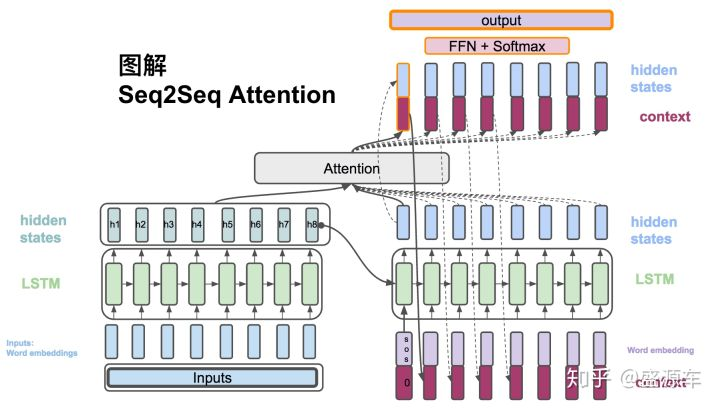

在luong中提到了三种score的计算方法

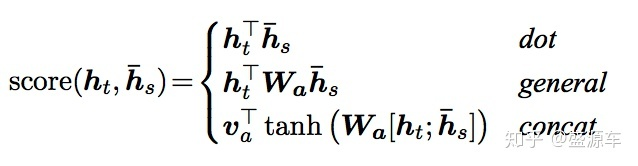

In [128]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.GRU(embed_size, enc_hidden_size, batch_first=True, bidirectional=True)
        # bidirectional=True双向
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()
        # print(hid.shape)=torch.Size([2, batch_size, enc_hidden_size])
        
        hid = torch.cat([hid[-2], hid[-1]], dim=1) # 双向需要拼接
        # print(hid.shape)= torch.Size([batch_size, 2*enc_hidden_size])
        hid = torch.tanh(self.fc(hid)).unsqueeze(0)
        # print(hid.shape)=torch.Size([1, batch_size, dec_hidden_size])
        # print(out.shape)=torch.Size([batch_size, seq_len, 2*enc_hidden_size])
        # 这两步我的理解，目的就是上两步的([2, batch_size, enc_hidden_size])变成([1, batch_size, dec_hidden_size])
        return out, hid

#### Luong Attention
- 根据context vectors和当前的输出hidden states，计算输出

这里我们计算第二种score的计算方法

In [129]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        # enc_hidden_size跟Encoder的一样
        super(Attention, self).__init__()

        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size

        self.linear_in = nn.Linear(enc_hidden_size*2, dec_hidden_size, bias=False)
        self.linear_out = nn.Linear(enc_hidden_size*2 + dec_hidden_size, dec_hidden_size)
        
    def forward(self, output, context, mask):
        # mask = batch_size, output_len, context_len # mask在Decoder中创建好了
        # output: batch_size, output_len, dec_hidden_size，就是Decoder的output
        # context: batch_size, context_len, 2*enc_hidden_size，就是Encoder的output
        # 这里Encoder网络是双向的，Decoder是单向的。
    
        batch_size = output.size(0)
        output_len = output.size(1)
        input_len = context.size(1) # input_len = context_len
        
        # 开始计算score，用到了第二种公式计算方式，先看懂这个网址：https://zhuanlan.zhihu.com/p/40920384
        # 通过decoder的hidden states加上encoder的hidden states来计算一个分数，用于计算权重
        context_in = self.linear_in(context.view(batch_size*input_len, -1)).view(                
            batch_size, input_len, -1) # batch_size, context_len, dec_hidden_size
        # 第一步，公式里的Wa先与hs做点乘，把Encoder output的enc_hidden_size换成dec_hidden_size。
        
        # context_in.transpose(1,2): batch_size, dec_hidden_size, context_len 
        # output: batch_size, output_len, dec_hidden_size
        attn = torch.bmm(output, context_in.transpose(1,2)) 
        # batch_size, output_len, context_len
        # 第二步，ht与上一步结果点乘，得到score

        attn.data.masked_fill(mask, -1e6)
        # .masked_fill作用请看这个链接：https://blog.csdn.net/candy134834/article/details/84594754
        # mask的维度必须和attn维度相同，mask为1的位置对应attn的位置的值替换成-1e6，
        # mask为1的意义需要看Decoder函数里面的定义

        attn = F.softmax(attn, dim=2) 
        # batch_size, output_len, context_len
        # 这个dim=2到底是怎么softmax的看下下面单元格例子
        # 第三步，计算每一个encoder的hidden states对应的权重。
        
        # context: batch_size, context_len, 2*enc_hidden_size，
        context = torch.bmm(attn, context) 
        # batch_size, output_len, 2*enc_hidden_size
        # 第四步，得出context vector是一个对于encoder输出的hidden states的一个加权平均
        
        # output: batch_size, output_len, dec_hidden_size
        output = torch.cat((context, output), dim=2) 
        # output：batch_size, output_len, 2*enc_hidden_size+dec_hidden_size
        # 第五步，将context vector和 decoder的hidden states 串起来。
        
        output = output.view(batch_size*output_len, -1)
        # output.shape = (batch_size*output_len, 2*enc_hidden_size+dec_hidden_size)
        output = torch.tanh(self.linear_out(output)) 
        # output.shape=(batch_size*output_len, dec_hidden_size)
        output = output.view(batch_size, output_len, -1)
        # output.shape=(batch_size, output_len, dec_hidden_size)
        # attn.shape = batch_size, output_len, context_len


        return output, attn

In [130]:
a = torch.ones([2, 3, 4]) # 两组，三行，四列
print(a)
b = F.softmax(a, dim=0)  # 代码在第一个维度softmax，第一个维度有两个数字softmax，0.5 + 0.5 =1
print(b)
print("---"*10)
b = F.softmax(a, dim=1) # 第二个维度按三行操作，第一组的每行有三个数据，0.33+0.33+0.33 = 1，第二组同样计算。
print(b)
print("---"*10)
b = F.softmax(a, dim=2) # 第三个维度按四列操作，第一行有4列数据，0.25+0.25+0.25+0.25 = 1，总共有6行需要类似计算。
print(b)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
tensor([[[0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000]]])
------------------------------
tensor([[[0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333]],

        [[0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333],
         [0.3333, 0.3333, 0.3333, 0.3333]]])
------------------------------
tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.250

#### Decoder
- decoder会根据已经翻译的句子内容，和context vectors，来决定下一个输出的单词

In [131]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.out = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, x_len, y_len):
        # x_len 是一个batch中文句子的长度列表，需要注意。
        # y_len 是一个batch英文句子的长度列表
        # a mask of shape x_len * y_len
        device = x_len.device
        max_x_len = x_len.max()
        max_y_len = y_len.max()
        
#       print(torch.arange(max_x_len, device=x_len.device)[None, :])
#       tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], device='cuda:0') =(1,max_x_len)

#       print(x_len[:, None])
#       ensor([[ 9],[6], [ 8],...,[10]], device='cuda:0') =(batch_size,1)
        
        x_mask = torch.arange(max_x_len, device=x_len.device)[None, :] < x_len[:, None]
        # print(x_mask.shape) = (batch_size, output_len) # 中文句子的mask
        
#       print(x_mask) 就是batch里每个句子长度都变成（1，max_x_len），然后一个句子不够长的位置的填充0。
#       tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], # 第一个句子长度是9，所以在第10个位置填充0
#       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0], # 第二个句子长度是6，所以后4个填充0
#       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
#       ........
#       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0', dtype=torch.uint8)

        y_mask = torch.arange(max_y_len, device=x_len.device)[None, :] < y_len[:, None]
        # y_mask同理
        # print(y_mask.shape) = (batch_size, context_len) # 英文句子的mask
        
        mask = (1 - x_mask[:, :, None] * y_mask[:, None, :]).byte()
        # 1-说明取反
        # x_mask[:, :, None] = (batch_size, output_len, 1)
        # y_mask[:, None, :] =  (batch_size, 1, context_len)
        # print(mask.shape) #= (batch_size, output_len, context_len)
        # 注意这个例子的*相乘不是torch.bmm矩阵点乘，只是用到了广播机制而已。
        return mask
    
    def forward(self, ctx, ctx_lengths, y, y_lengths, hid):
        # ctx = 
        
        # Encoder可以不用下面操作，Decoder还是需要的
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()]
        
        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, output_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()

        mask = self.create_mask(y_lengths, ctx_lengths) # 这里真是坑，第一个参数位置是中文句子的长度列表

        output, attn = self.attention(output_seq, ctx, mask) 
        # output.shape=(batch_size, output_len, dec_hidden_size)
        # attn.shape = batch_size, output_len, context_len
        
        
        # self.out = nn.Linear(dec_hidden_size, vocab_size)
        output = F.log_softmax(self.out(output), -1) # 计算最后的输出概率
        # output =(batch_size, output_len, vocab_size)
        # 最后一个vocab_size维度 log_softmax
        # hid.shape = (1, batch_size, dec_hidden_size)
        return output, hid, attn

#### Seq2Seq
- 最后我们构建Seq2Seq模型把encoder, attention, decoder串到一起

In [133]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        # print(hid.shape)=torch.Size([1, batch_size, dec_hidden_size])
        # print(out.shape)=torch.Size([batch_size, seq_len, 2*enc_hidden_size])
        output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        # output =(batch_size, output_len, vocab_size)
        # hid.shape = (1, batch_size, dec_hidden_size)
        # attn.shape = (batch_size, output_len, context_len)
        return output, attn
    
    # 同上
    def translate(self, x, x_lengths, y, max_length=100):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            attns.append(attn)
        return torch.cat(preds, 1), torch.cat(attns, 1)

训练

In [134]:
dropout = 0.2
embed_size = hidden_size = 100
encoder = Encoder(vocab_size=en_total_words,
                       embed_size=embed_size,
                      enc_hidden_size=hidden_size,
                       dec_hidden_size=hidden_size,
                      dropout=dropout)
decoder = Decoder(vocab_size=cn_total_words,
                      embed_size=embed_size,
                      enc_hidden_size=hidden_size,
                       dec_hidden_size=hidden_size,
                      dropout=dropout)
model = Seq2Seq(encoder, decoder)
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [137]:
train(model, train_data, num_epochs=30)

Epoch 0 iteration 0 loss 5.134828090667725
Epoch 0 iteration 100 loss 4.685793399810791
Epoch 0 iteration 200 loss 4.721463680267334
Epoch 0 Training loss 4.795956769472762
Evaluation loss 4.544913798995012
Epoch 1 iteration 0 loss 4.718827247619629
Epoch 1 iteration 100 loss 4.218364238739014
Epoch 1 iteration 200 loss 4.31178092956543
Epoch 1 Training loss 4.371544330893589
Epoch 2 iteration 0 loss 4.353080749511719
Epoch 2 iteration 100 loss 3.8525094985961914
Epoch 2 iteration 200 loss 3.984410047531128
Epoch 2 Training loss 4.041675830052729
Epoch 3 iteration 0 loss 4.09982967376709
Epoch 3 iteration 100 loss 3.586416721343994
Epoch 3 iteration 200 loss 3.7307956218719482
Epoch 3 Training loss 3.7934063133359173
Epoch 4 iteration 0 loss 3.8587112426757812
Epoch 4 iteration 100 loss 3.3827362060546875
Epoch 4 iteration 200 loss 3.501173496246338
Epoch 4 Training loss 3.593038312016805
Epoch 5 iteration 0 loss 3.7009503841400146
Epoch 5 iteration 100 loss 3.17336106300354
Epoch 5 it

In [138]:
for i in range(100,120):
    translate_dev(i)
    print()

BOS you have nice skin . EOS
BOS 你 的 皮 膚 真 好 。 EOS
你有敌人。

BOS you 're UNK correct . EOS
BOS 你 部 分 正 确 。 EOS
你做了事情。

BOS everyone admired his courage . EOS
BOS 每 個 人 都 佩 服 他 的 勇 氣 。 EOS
每一個人都想让他的喜歡。

BOS what time is it ? EOS
BOS 几 点 了 ？ EOS
这么什么？

BOS i 'm free tonight . EOS
BOS 我 今 晚 有 空 。 EOS
我今晚是免費的。

BOS here is your book . EOS
BOS 這 是 你 的 書 。 EOS
你的書在书。

BOS they are at lunch . EOS
BOS 他 们 在 吃 午 饭 。 EOS
他们在午午餐。

BOS this chair is UNK . EOS
BOS 這 把 椅 子 很 UNK 。 EOS
這件椅子是個木制的。

BOS it 's pretty heavy . EOS
BOS 它 真 重 。 EOS
它真的很好。

BOS many attended his funeral . EOS
BOS 很 多 人 都 参 加 了 他 的 葬 礼 。 EOS
許多人終於他的行李。

BOS training will be provided . EOS
BOS 会 有 训 练 。 EOS
日本可以離開。

BOS someone is watching you . EOS
BOS 有 人 在 看 著 你 。 EOS
有人在看看你。

BOS i slapped his face . EOS
BOS 我 摑 了 他 的 臉 。 EOS
我承諾自己的。

BOS i like UNK music . EOS
BOS 我 喜 歡 流 行 音 樂 。 EOS
我喜欢音乐。

BOS tom had no children . EOS
BOS T o m 沒 有 孩 子 。 EOS
汤姆没有孩子。

BOS please lock the door . EOS
BOS 請 把 門 鎖 上 。 EOS
請關門。

BOS tom has cal